In [ ]:
# import libraries
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn import linear_model
from sklearn import model_selection
from sklearn import metrics
from sklearn import neighbors
from sklearn import pipeline
from sklearn import preprocessing
from sklearn import pipeline
from sklearn import tree

random_state=42

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Understanding
Source: https://www.kaggle.com/datasets/shubhambathwal/flight-price-prediction

In [ ]:
# data import
path = '/content/drive/MyDrive/'
file_name = 'flight_data.csv'
file_path = os.path.join(path, file_name)

df = pd.read_csv(file_path)

df.head()

,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        300153 non-null  int64  
 1   airline           300153 non-null  object 
 2   flight            300153 non-null  object 
 3   source_city       300153 non-null  object 
 4   departure_time    300153 non-null  object 
 5   stops             300153 non-null  object 
 6   arrival_time      300153 non-null  object 
 7   destination_city  300153 non-null  object 
 8   class             300153 non-null  object 
 9   duration          300153 non-null  float64
 10  days_left         300153 non-null  int64  
 11  price             300153 non-null  int64  
dtypes: float64(1), int64(3), object(8)
memory usage: 27.5+ MB


**Initial Insights:**
* 300,153 values
* 12 columns (including a redundant index). 
* No null values.
* target variable: 'price'
* regression problem



## Categorical

In [ ]:
def create_categorical_barcharts(col, data=df):
  df[col].value_counts().plot(kind='barh', xlabel = 'value', ylabel='count', stacked=True, title = '{} count'.format(col))
  plt.rcParams["figure.figsize"] = (20,3)
  plt.show()


  df[col].value_counts(normalize=True).plot(kind='barh', xlabel = 'value', ylabel='proportion', title = '{} proportion'.format(col))
  plt.rcParams["figure.figsize"] = (20,3)
  plt.show()


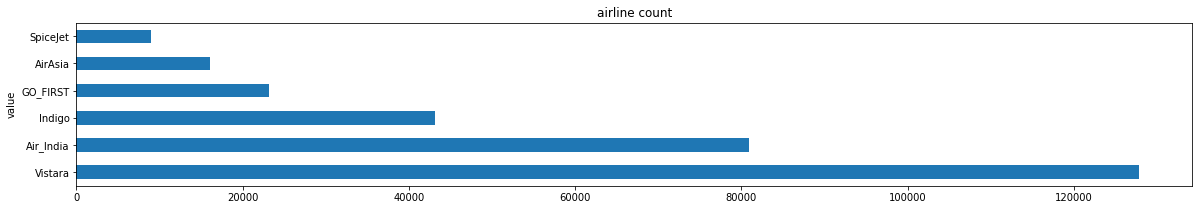

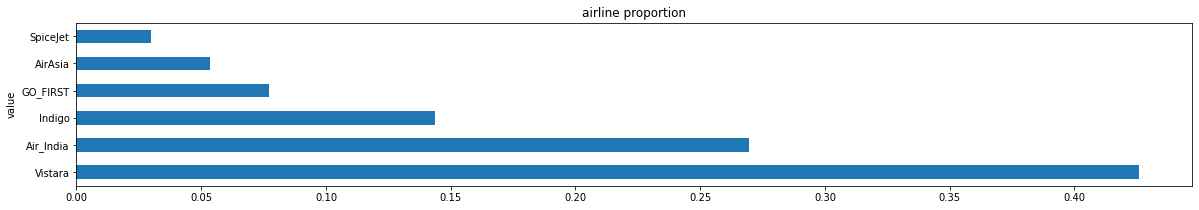

In [ ]:
create_categorical_barcharts('airline')

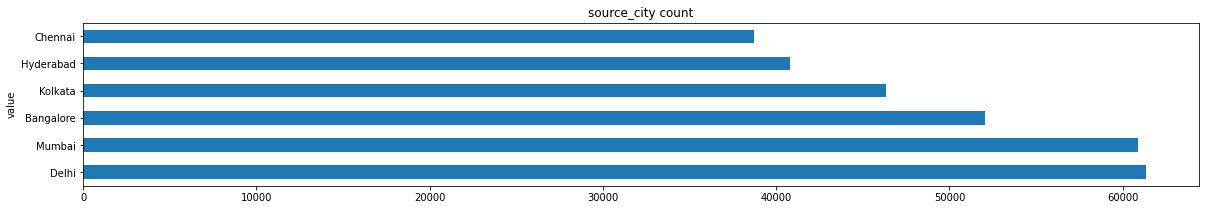

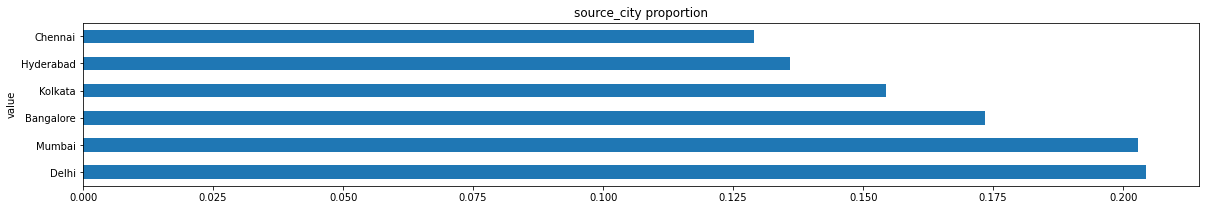

In [ ]:
create_categorical_barcharts('source_city')

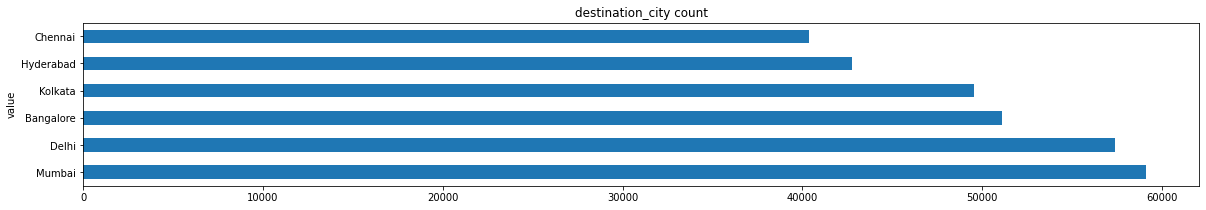

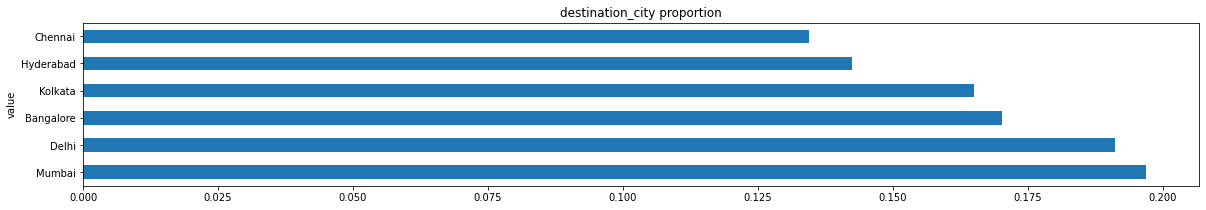

In [ ]:
create_categorical_barcharts('destination_city')

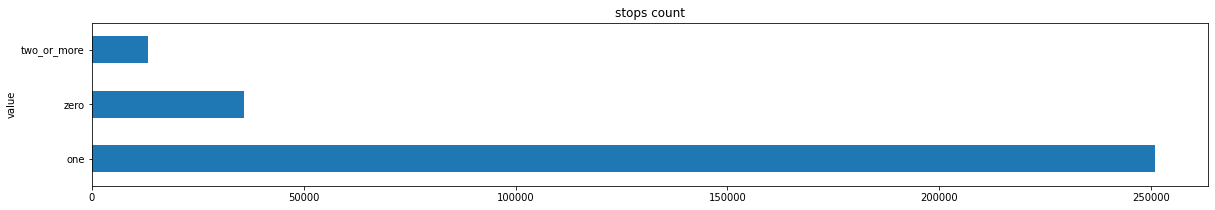

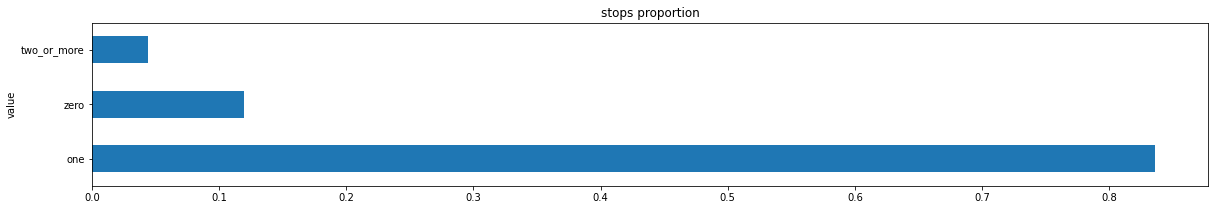

In [ ]:
create_categorical_barcharts('stops')

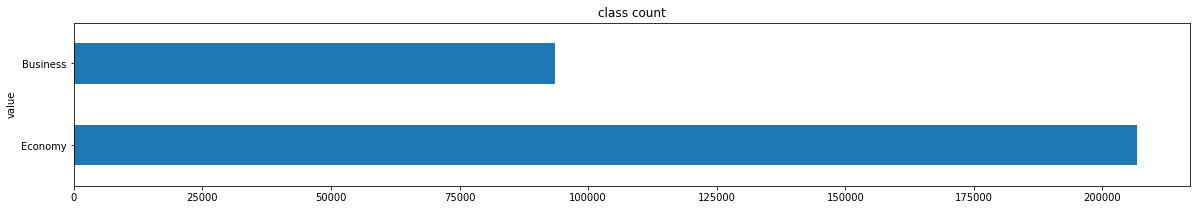

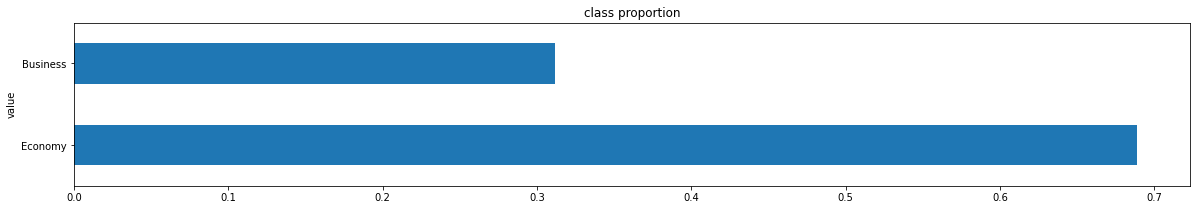

In [ ]:
create_categorical_barcharts('class')

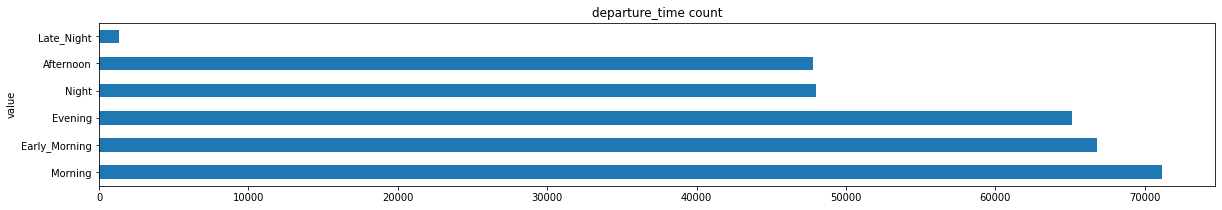

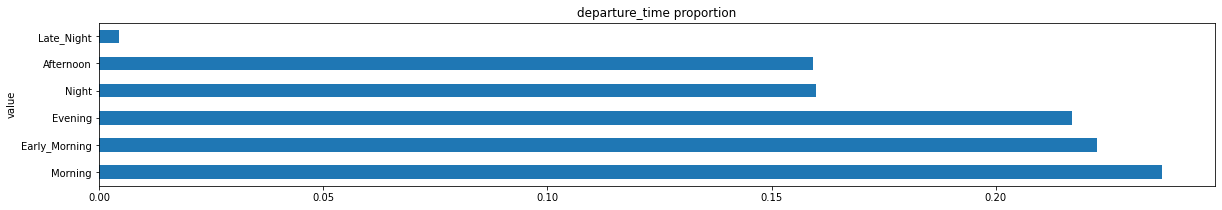

In [ ]:
create_categorical_barcharts('departure_time')

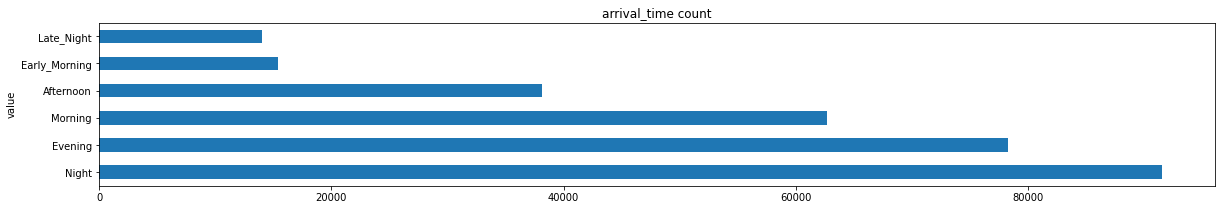

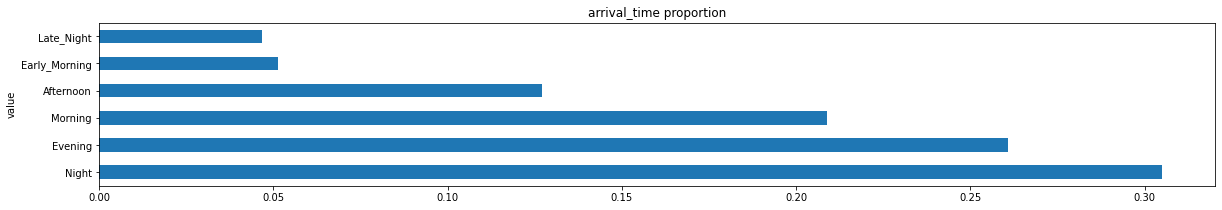

In [ ]:
create_categorical_barcharts('arrival_time')

## Numerical

In [ ]:
num_cols = ['days_left', 'duration', 'price']

# statistical distributions
df[num_cols].describe()

,days_left,duration,price
count,300153.000000,300153.000000,300153.000000
mean,26.004751,12.221021,20889.660523
std,13.561004,7.191997,22697.767366
min,1.000000,0.830000,1105.000000
25%,15.000000,6.830000,4783.000000
50%,26.000000,11.250000,7425.000000
75%,38.000000,16.170000,42521.000000
max,49.000000,49.830000,123071.000000


In [ ]:
def get_numerical_distribution(col, bins=30, data=df):
  data[col].plot(kind='box', vert=False, title = '{} Distribution'.format(col))
  plt.show()

  # histogram with bins=30 to show distribution
  plt.hist(data[col], edgecolor="black", bins=bins)
  plt.xlabel(col)
  plt.ylabel("count")
  plt.show()

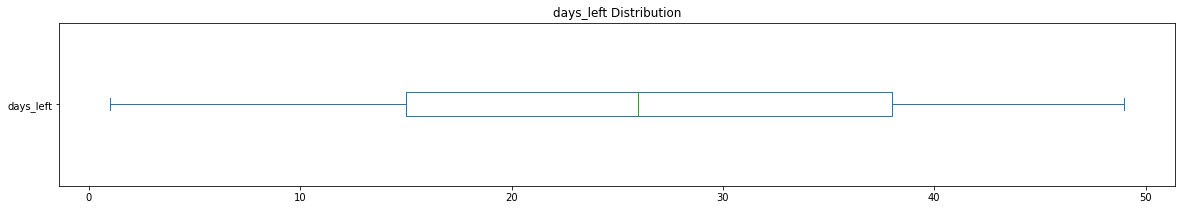

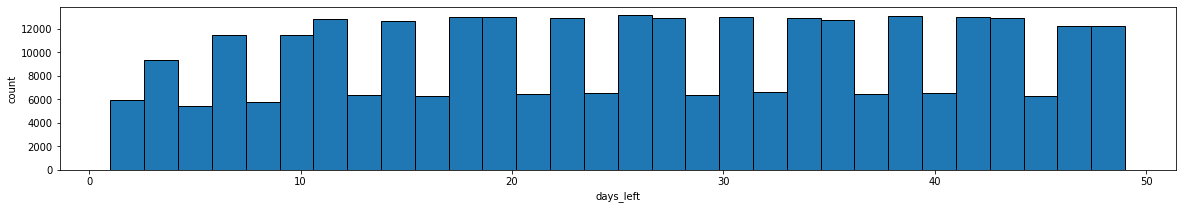

In [ ]:
get_numerical_distribution('days_left')

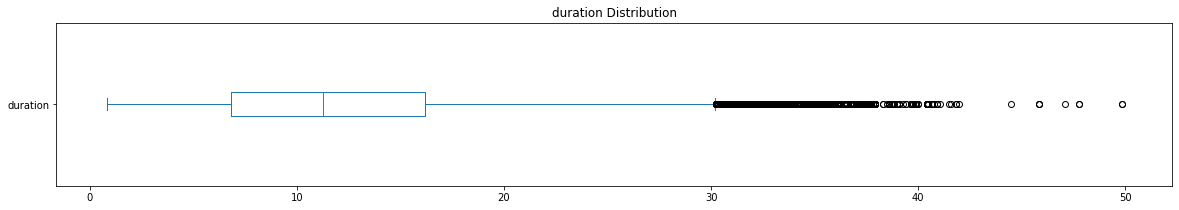

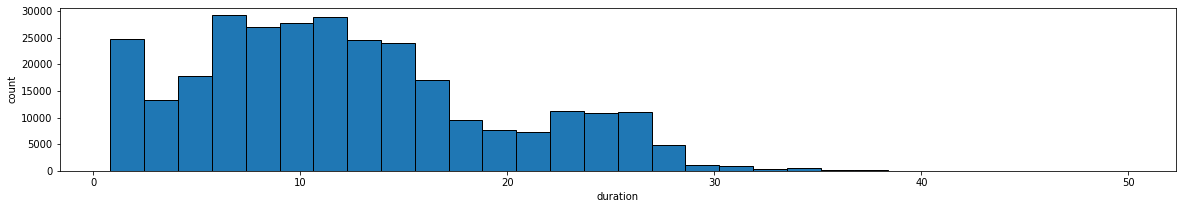

In [ ]:
get_numerical_distribution('duration')

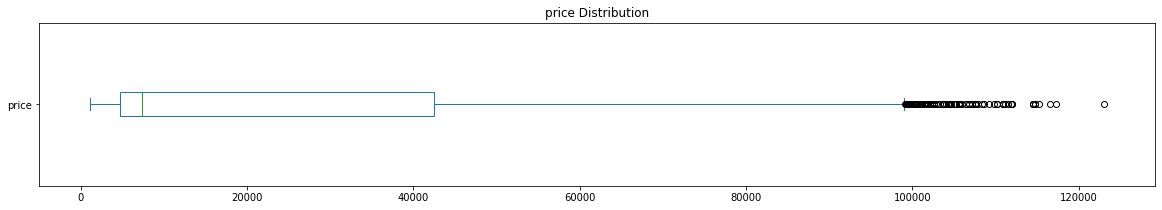

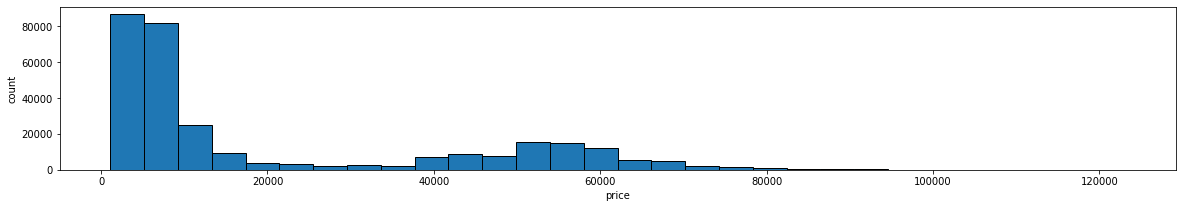

In [ ]:
# distribution of price
get_numerical_distribution('price')

Price has a bimodal distribution

In [ ]:
corr = df[num_cols].corr()
corr.style.background_gradient(cmap='gray')

,days_left,duration,price
days_left,1.000000,-0.039157,-0.091949
duration,-0.039157,1.000000,0.204222
price,-0.091949,0.204222,1.000000


In [ ]:
# split into business and travel
df_economy = df.loc[df['class'] == 'Economy'].copy()
df_business = df.loc[df['class'] == 'Business'].copy()

df_economy.head()

,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


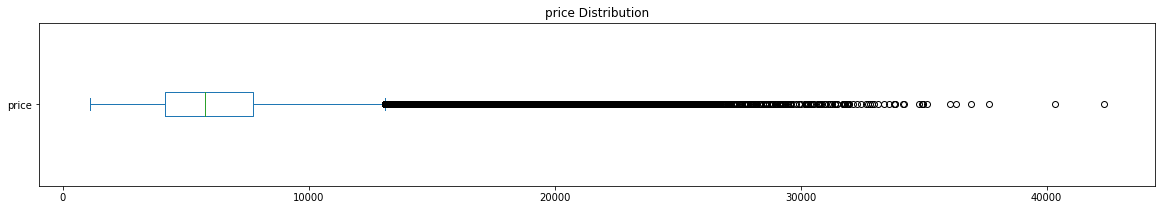

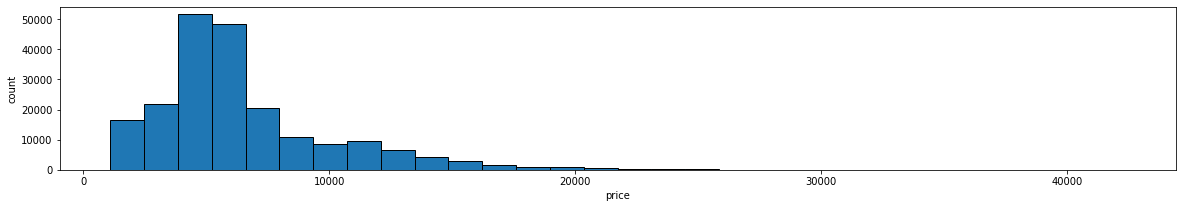

In [ ]:
# distribution of price
get_numerical_distribution('price', data=df_economy)

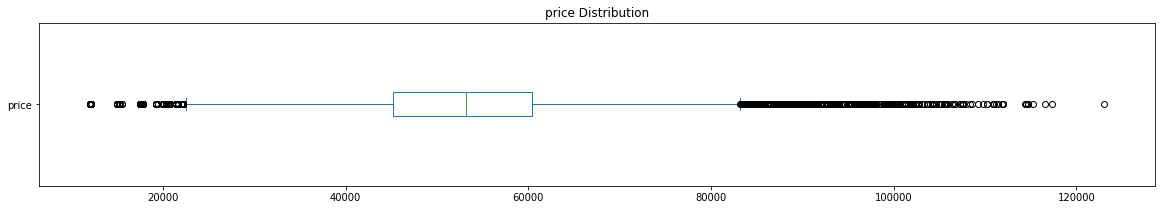

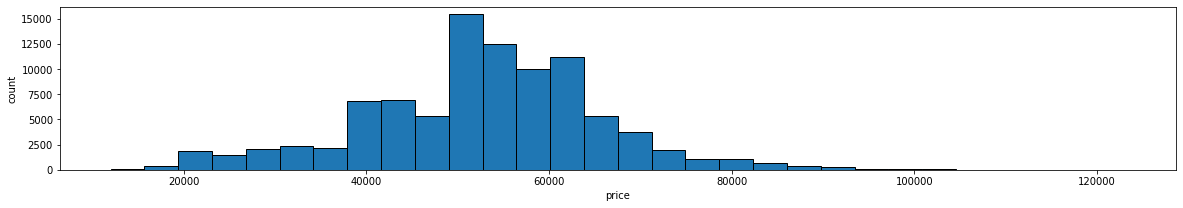

In [ ]:
# distribution of price
get_numerical_distribution('price', data=df_business)

# Data Preparation

## Cleaning

In [ ]:
# drop the first column which is a redundant index
Xy = df.iloc[:, 1:].copy()

# drop flight as it is high cardinality and low information
Xy.drop(['flight'], axis=1, inplace=True)

Xy.head()

,airline,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,Vistara,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,Vistara,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


## Encoding

In [ ]:
def one_hot_encode(col, data):  
  df = data.copy()
  
  ohe = pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=False)
  
  df = df.join(ohe)

  return df

In [ ]:
# iterate over categorical data and one hot encode
ohe_list = ['class', 'airline', 'source_city', 'destination_city', 'departure_time', 'arrival_time', 'stops']

Xy_ohe = Xy.copy()

for col in ohe_list:
  Xy_ohe = one_hot_encode(col, Xy_ohe)

In [ ]:
# iterate over categorical data and label encode
def label_encode(col, data):
  df = data.copy()

  col_e = col + '_e'

  labelencoder = preprocessing.LabelEncoder()
  df[col_e] = labelencoder.fit_transform(df[col])
  
  return df

In [ ]:
for col in ohe_list:
  Xy = label_encode(col, Xy)

Xy.columns

Index(['airline', 'source_city', 'departure_time', 'stops', 'arrival_time',
       'destination_city', 'class', 'duration', 'days_left', 'price',
       'class_e', 'airline_e', 'source_city_e', 'destination_city_e',
       'departure_time_e', 'arrival_time_e', 'stops_e'],
      dtype='object')

In [ ]:
# create X and y by class
Xy_e = Xy.loc[Xy['class'] == 'Economy'].reset_index(drop=True).copy()
Xy_b = Xy.loc[Xy['class'] != 'Economy'].reset_index(drop=True).copy()

In [ ]:
# create X and y ohe by class
Xy_e_ohe = Xy_ohe.loc[Xy_ohe['class'] == 'Economy'].reset_index(drop=True).copy()
Xy_b_ohe = Xy_ohe.loc[Xy_ohe['class'] != 'Economy'].reset_index(drop=True).copy()

## Train Test Split


In [ ]:
# target
target = 'price'

# root mean squared error as our metric
scoring = 'neg_root_mean_squared_error'

# folds for nested cross-validation. Only 5 because so much data.
inner_cv = model_selection.KFold(n_splits=5, shuffle=True, random_state=random_state)
outer_cv = model_selection.KFold(n_splits=5, shuffle=True, random_state=random_state)

In [ ]:
# X and y
le_drop_list = ohe_list + [target]

X = Xy.drop(le_drop_list, axis=1).copy()
y = Xy[[target]].copy()

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, 
                                                                    y, 
                                                                    test_size=0.20, 
                                                                    random_state=random_state) 

X.columns

Index(['duration', 'days_left', 'class_e', 'airline_e', 'source_city_e',
       'destination_city_e', 'departure_time_e', 'arrival_time_e', 'stops_e'],
      dtype='object')

In [ ]:
# X_e and y_e
X_e = Xy_e.drop(le_drop_list, axis=1).copy()
y_e = Xy_e[[target]].copy()

X_e_train, X_e_test, y_e_train, y_e_test = model_selection.train_test_split(X_e, 
                                                                    y_e, 
                                                                    test_size=0.20, 
                                                                    random_state=random_state) 

X_e.columns


Index(['duration', 'days_left', 'class_e', 'airline_e', 'source_city_e',
       'destination_city_e', 'departure_time_e', 'arrival_time_e', 'stops_e'],
      dtype='object')

In [ ]:
# X_b and y_b
X_b = Xy_b.drop(le_drop_list, axis=1).copy()
y_b = Xy_b[[target]].copy()

X_b_train, X_b_test, y_b_train, y_b_test = model_selection.train_test_split(X_b, 
                                                                    y_b, 
                                                                    test_size=0.20, 
                                                                    random_state=random_state)

X_b.columns

Index(['duration', 'days_left', 'class_e', 'airline_e', 'source_city_e',
       'destination_city_e', 'departure_time_e', 'arrival_time_e', 'stops_e'],
      dtype='object')

In [ ]:
# X_ohe and y_ohe
ohe_drop_list = ohe_list + ['class_Business',
                 'airline_Air_India',
                 'source_city_Chennai',
                 'destination_city_Chennai',
                 'departure_time_Early_Morning',
                 'arrival_time_Early_Morning',
                 'stops_zero'
                 ] + [target]


X_ohe = Xy_ohe.drop(ohe_drop_list, axis=1).copy()
y_ohe = Xy_ohe[[target]].copy()

X_ohe_train, X_ohe_test, y_ohe_train, y_ohe_test = model_selection.train_test_split(X_ohe, 
                                                                    y_ohe, 
                                                                    test_size=0.20, 
                                                                    random_state=random_state) 

X_ohe.columns

Index(['duration', 'days_left', 'class_Economy', 'airline_AirAsia',
       'airline_GO_FIRST', 'airline_Indigo', 'airline_SpiceJet',
       'airline_Vistara', 'source_city_Bangalore', 'source_city_Delhi',
       'source_city_Hyderabad', 'source_city_Kolkata', 'source_city_Mumbai',
       'destination_city_Bangalore', 'destination_city_Delhi',
       'destination_city_Hyderabad', 'destination_city_Kolkata',
       'destination_city_Mumbai', 'departure_time_Afternoon',
       'departure_time_Evening', 'departure_time_Late_Night',
       'departure_time_Morning', 'departure_time_Night',
       'arrival_time_Afternoon', 'arrival_time_Evening',
       'arrival_time_Late_Night', 'arrival_time_Morning', 'arrival_time_Night',
       'stops_one', 'stops_two_or_more'],
      dtype='object')

In [ ]:
# X_e_ohe and y_b_ohe
ohe_drop_list = ohe_list + ['class_Business',
                 'airline_Air_India',
                 'source_city_Chennai',
                 'destination_city_Chennai',
                 'departure_time_Early_Morning',
                 'arrival_time_Early_Morning',
                 'stops_zero'
                 ] + [target, 'class_Economy']

X_e_ohe = Xy_e_ohe.drop(ohe_drop_list, axis=1).copy()
y_e_ohe = Xy_e_ohe[[target]].copy()

X_e_ohe_train, X_e_ohe_test, y_e_ohe_train, y_e_ohe_test = model_selection.train_test_split(X_e_ohe, 
                                                                    y_e_ohe, 
                                                                    test_size=0.20, 
                                                                    random_state=random_state) 

X_e_ohe.columns

Index(['duration', 'days_left', 'airline_AirAsia', 'airline_GO_FIRST',
       'airline_Indigo', 'airline_SpiceJet', 'airline_Vistara',
       'source_city_Bangalore', 'source_city_Delhi', 'source_city_Hyderabad',
       'source_city_Kolkata', 'source_city_Mumbai',
       'destination_city_Bangalore', 'destination_city_Delhi',
       'destination_city_Hyderabad', 'destination_city_Kolkata',
       'destination_city_Mumbai', 'departure_time_Afternoon',
       'departure_time_Evening', 'departure_time_Late_Night',
       'departure_time_Morning', 'departure_time_Night',
       'arrival_time_Afternoon', 'arrival_time_Evening',
       'arrival_time_Late_Night', 'arrival_time_Morning', 'arrival_time_Night',
       'stops_one', 'stops_two_or_more'],
      dtype='object')

In [ ]:
# X_b_ohe and y_b_ohe
X_b_ohe = Xy_b_ohe.drop(ohe_drop_list, axis=1).copy()
y_b_ohe = Xy_b_ohe[[target]].copy()

X_b_ohe_train, X_b_ohe_test, y_b_ohe_train, y_b_ohe_test = model_selection.train_test_split(X_b_ohe, 
                                                                    y_b_ohe, 
                                                                    test_size=0.20, 
                                                                    random_state=random_state) 

X_b_ohe.columns

Index(['duration', 'days_left', 'airline_AirAsia', 'airline_GO_FIRST',
       'airline_Indigo', 'airline_SpiceJet', 'airline_Vistara',
       'source_city_Bangalore', 'source_city_Delhi', 'source_city_Hyderabad',
       'source_city_Kolkata', 'source_city_Mumbai',
       'destination_city_Bangalore', 'destination_city_Delhi',
       'destination_city_Hyderabad', 'destination_city_Kolkata',
       'destination_city_Mumbai', 'departure_time_Afternoon',
       'departure_time_Evening', 'departure_time_Late_Night',
       'departure_time_Morning', 'departure_time_Night',
       'arrival_time_Afternoon', 'arrival_time_Evening',
       'arrival_time_Late_Night', 'arrival_time_Morning', 'arrival_time_Night',
       'stops_one', 'stops_two_or_more'],
      dtype='object')

# Modeling

In [ ]:
# function for weighting RMSE results by proportion of data
e_weight = len(y_e.index) / len(y.index)
b_weight = len(y_b.index) / len(y.index)

def calculate_avg_score(e_rmse, b_rmse, e_weight=e_weight, b_weight=b_weight):
  avg_rmse = e_rmse * e_weight + b_rmse * b_weight

  return avg_rmse

## Phase 1

### Linear Regression

In [ ]:
# fit a basic regression
clf_lr = linear_model.LinearRegression(n_jobs=-1,
                                       fit_intercept=True,
                                       positive=False)

clf_lr_fit = clf_lr.fit(X_ohe_train, y_ohe_train)

# generalization performance
nested_lr_fit = model_selection.cross_val_score(
    clf_lr_fit, 
    X=X_ohe_train, 
    y=y_ohe_train, 
    scoring=scoring,
    cv=outer_cv)

print("General {} mean: ".format(scoring), round(-1 * nested_lr_fit.mean(), 2), " with st.dev (+/-): ", round(nested_lr_fit.std(),2))

General neg_root_mean_squared_error mean:  6753.15  with st.dev (+/-):  27.65


In [ ]:
# fit a basic regression
clf_lr = linear_model.LinearRegression(n_jobs=-1,
                                       fit_intercept=True,
                                       positive=False)

clf_lr_fit = clf_lr.fit(X_e_ohe_train, y_e_ohe_train)


# generalization performance
nested_lr_fit= model_selection.cross_val_score(
    clf_lr_fit, 
    X=X_e_ohe_train, 
    y=y_e_ohe_train, 
    scoring=scoring,
    cv=outer_cv)

print("Economy {} mean: ".format(scoring), round(-1 * nested_lr_fit.mean(), 2), " with st.dev (+/-): ", round(nested_lr_fit.std(),2))

e_rmse = -1 * nested_lr_fit.mean()

Economy neg_root_mean_squared_error mean:  2855.13  with st.dev (+/-):  10.14


In [ ]:
# fit a basic regression
clf_lr = linear_model.LinearRegression(n_jobs=-1,
                                       fit_intercept=True,
                                       positive=False)

clr_lr_fit = clf_lr.fit(X_b_ohe_train, y_b_ohe_train)

# generalization performance
nested_lr_fit= model_selection.cross_val_score(
    clf_lr_fit, 
    X=X_b_ohe_train, 
    y=y_b_ohe_train, 
    scoring=scoring,
    cv=outer_cv)

print("Business {} mean: ".format(scoring), round(-1 * nested_lr_fit.mean(), 2), " with st.dev (+/-): ", round(nested_lr_fit.std(),2))

b_rmse = -1 * nested_lr_fit.mean()

Business neg_root_mean_squared_error mean:  9380.35  with st.dev (+/-):  36.85


In [ ]:
avg_rmse = calculate_avg_score(e_rmse, b_rmse)
print(round(avg_rmse, 2))

4603.54


### Decision Tree

In [ ]:
clf_tree = tree.DecisionTreeRegressor(criterion='squared_error',
                                      min_samples_split=20,
                                      max_depth=20,
                                      random_state=random_state)

clf_tree_fit = clf_tree.fit(X_train, y_train)

# generalization performance
nested_tree_fit = model_selection.cross_val_score(
    clf_tree_fit, 
    X=X_train, 
    y=y_train, 
    scoring=scoring,
    cv=outer_cv)

print("General {} mean: ".format(scoring), round(-1 * nested_tree_fit.mean(), 2), " with st.dev (+/-): ", round(nested_tree_fit.std(),2))

General neg_root_mean_squared_error mean:  3061.45  with st.dev (+/-):  9.29


In [ ]:
clf_tree = tree.DecisionTreeRegressor(criterion='squared_error',
                                      min_samples_split=20,
                                      max_depth=20,
                                      random_state=random_state)

clf_tree_fit = clf_tree.fit(X_e_train, y_e_train)

# generalization performance
nested_tree_fit = model_selection.cross_val_score(
    clf_tree_fit, 
    X=X_e_train, 
    y=y_e_train, 
    scoring=scoring,
    cv=outer_cv)

print("General {} mean: ".format(scoring), round(-1 * nested_tree_fit.mean(), 2), " with st.dev (+/-): ", round(nested_tree_fit.std(),2))

e_rmse = -1 * nested_tree_fit.mean()

General neg_root_mean_squared_error mean:  1712.58  with st.dev (+/-):  12.46


In [ ]:
clf_tree = tree.DecisionTreeRegressor(criterion='squared_error',
                                      min_samples_split=10,
                                      max_depth=15,
                                      random_state=random_state)

clf_tree_fit = clf_tree.fit(X_b_train, y_b_train)

# generalization performance
nested_tree_fit = model_selection.cross_val_score(
    clf_tree_fit, 
    X=X_b_train, 
    y=y_b_train, 
    scoring=scoring,
    cv=outer_cv)

print("General {} mean: ".format(scoring), round(-1 * nested_tree_fit.mean(), 2), " with st.dev (+/-): ", round(nested_tree_fit.std(),2))

b_rmse = -1 * nested_tree_fit.mean()

General neg_root_mean_squared_error mean:  5572.32  with st.dev (+/-):  78.25


In [ ]:
avg_rmse = calculate_avg_score(e_rmse, b_rmse)
print(round(avg_rmse, 2))

2914.75


## Phase 2

### Linear Regression

In [ ]:
clf_lr = linear_model.LinearRegression(n_jobs=-1)

# two parameters to optimize
fit_intercept_list = [True, False]
positive_list = [True, False]

# select the optimal parameters
gs_lr = model_selection.GridSearchCV(
    estimator=clf_lr,
    param_grid=[{
        'fit_intercept': fit_intercept_list,
        'positive': positive_list}],
    scoring=scoring,                                      
    cv=inner_cv) 

gs_lr_fit = gs_lr.fit(X_ohe_train,y_ohe_train)

print('General')
print("Non-nested Tuning:")
print("  Model: ", gs_lr_fit.best_estimator_)
print("  Parameterization: ", gs_lr_fit.best_params_)
print("  Non-nested CV {} score: ".format(scoring), round(-1 * gs_lr_fit.best_score_, 2))


# generalization performance
nested_gs_lr_fit= model_selection.cross_val_score(
    gs_lr_fit, 
    X=X_ohe_train, 
    y=y_ohe_train, 
    scoring=scoring,
    cv=outer_cv)

print("\nNested Tuning:")
print("  Nested CV {} mean: ".format(scoring), round(-1 * nested_gs_lr_fit.mean(), 2), " with st.dev (+/-): ", round(nested_gs_lr_fit.std(),2))

General
Non-nested Tuning:
  Model:  LinearRegression(n_jobs=-1)
  Parameterization:  {'fit_intercept': True, 'positive': False}
  Non-nested CV neg_root_mean_squared_error score:  6753.15

Nested Tuning:
  Nested CV neg_root_mean_squared_error mean:  6753.15  with st.dev (+/-):  27.65


In [ ]:
clf_lr = linear_model.LinearRegression(n_jobs=-1)

# two parameters to optimize
fit_intercept_list = [True, False]
positive_list = [True, False]

# select the optimal parameters
gs_lr = model_selection.GridSearchCV(
    estimator=clf_lr,
    param_grid=[{
        'fit_intercept': fit_intercept_list,
        'positive': positive_list}],
    scoring=scoring,                                      
    cv=inner_cv) 

gs_lr_fit = gs_lr.fit(X_e_ohe_train,y_e_ohe_train)

print('Economy')
print("Non-nested Tuning:")
print("  Model: ", gs_lr_fit.best_estimator_)
print("  Parameterization: ", gs_lr_fit.best_params_)
print("  Non-nested CV {} score: ".format(scoring), round(-1 * gs_lr_fit.best_score_, 2))


# generalization performance
nested_gs_lr_fit= model_selection.cross_val_score(
    gs_lr_fit, 
    X=X_e_ohe_train, 
    y=y_e_ohe_train, 
    scoring=scoring,
    cv=outer_cv)

print("\nNested Tuning:")
print("  Nested CV {} mean: ".format(scoring), round(-1 * nested_gs_lr_fit.mean(), 2), " with st.dev (+/-): ", round(nested_gs_lr_fit.std(),2))

e_rmse = -1 * nested_gs_lr_fit.mean()

Economy
Non-nested Tuning:
  Model:  LinearRegression(n_jobs=-1)
  Parameterization:  {'fit_intercept': True, 'positive': False}
  Non-nested CV neg_root_mean_squared_error score:  2648.86

Nested Tuning:
  Nested CV neg_root_mean_squared_error mean:  2648.86  with st.dev (+/-):  9.76


In [ ]:
clf_lr = linear_model.LinearRegression(n_jobs=-1)

# two parameters to optimize
fit_intercept_list = [True, False]
positive_list = [True, False]

# select the optimal parameters
gs_lr = model_selection.GridSearchCV(
    estimator=clf_lr,
    param_grid=[{
        'fit_intercept': fit_intercept_list,
        'positive': positive_list}],
    scoring=scoring,                                      
    cv=inner_cv) 

gs_lr_fit = gs_lr.fit(X_b_ohe_train,y_b_ohe_train)

print('Business')
print("Non-nested Tuning:")
print("  Model: ", gs_lr_fit.best_estimator_)
print("  Parameterization: ", gs_lr_fit.best_params_)
print("  Non-nested CV {} score: ".format(scoring), round(-1 * gs_lr_fit.best_score_, 2))


# generalization performance
nested_gs_lr_fit= model_selection.cross_val_score(
    gs_lr_fit, 
    X=X_b_ohe_train, 
    y=y_b_ohe_train, 
    scoring=scoring,
    cv=outer_cv)

print("\nNested Tuning:")
print("  Nested CV {} mean: ".format(scoring), round(-1 * nested_gs_lr_fit.mean(), 2), " with st.dev (+/-): ", round(nested_gs_lr_fit.std(),2))

b_rmse = -1 * nested_gs_lr_fit.mean()

Business
Non-nested Tuning:
  Model:  LinearRegression(n_jobs=-1)
  Parameterization:  {'fit_intercept': True, 'positive': False}
  Non-nested CV neg_root_mean_squared_error score:  8924.62

Nested Tuning:
  Nested CV neg_root_mean_squared_error mean:  8924.62  with st.dev (+/-):  45.18


In [ ]:
avg_rmse = calculate_avg_score(e_rmse, b_rmse)
print(round(avg_rmse, 2))

4603.54


### Decision Tree

In [ ]:
# create a model
clf_tree = tree.DecisionTreeRegressor(criterion='squared_error',
                                      random_state=random_state)

# two parameters to optimize
min_samples_split_list = [10, 20, 30, 40, 50]
max_depth_list = [10, 20, 30, 40, 50]

# select the optimal parameters 
gs_tree = model_selection.GridSearchCV(estimator=clf_tree,
                                       param_grid=[{
                                           'min_samples_split': min_samples_split_list,
                                           'max_depth': max_depth_list}],
                                       scoring=scoring,                                      
                                       cv=inner_cv) 

gs_tree_fit = gs_tree.fit(X_train,y_train)

print('General')
print("Non-nested Tuning:")
print("  Model: ", gs_tree_fit.best_estimator_)
print("  Parameterization: ", gs_tree_fit.best_params_)
print("  Non-nested CV {} score: ".format(scoring), round(-1 * gs_tree_fit.best_score_, 2))

# generalization performance
nested_gs_tree_fit = model_selection.cross_val_score(gs_tree_fit, 
                                                     X=X_train, 
                                                     y=y_train, 
                                                     scoring=scoring,
                                                     cv=outer_cv)

print("nested Tuning:")
print("  Nested CV {} mean: ".format(scoring), round(-1 * nested_gs_tree_fit.mean(),2), " with st.dev (+/-): ", round(nested_gs_tree_fit.std(),2))

General
Non-nested Tuning:
  Model:  DecisionTreeRegressor(max_depth=40, min_samples_split=30, random_state=42)
  Parameterization:  {'max_depth': 40, 'min_samples_split': 30}
  Non-nested CV neg_root_mean_squared_error score:  2971.93
nested Tuning:
  Nested CV neg_root_mean_squared_error mean:  2984.3  with st.dev (+/-):  14.75


In [ ]:
# create a model
clf_tree = tree.DecisionTreeRegressor(criterion='squared_error',
                                      random_state=random_state)

# two parameters to optimize
min_samples_split_list = [10, 20, 30, 40, 50]
max_depth_list = [10, 20, 30, 40, 50]

# select the optimal parameters 
gs_tree = model_selection.GridSearchCV(estimator=clf_tree,
                                       param_grid=[{
                                           'min_samples_split': min_samples_split_list,
                                           'max_depth': max_depth_list}],
                                       scoring=scoring,                                      
                                       cv=inner_cv) 

gs_tree_fit = gs_tree.fit(X_e_train,y_e_train)

print('Economy')
print("Non-nested Tuning:")
print("  Model: ", gs_tree_fit.best_estimator_)
print("  Parameterization: ", gs_tree_fit.best_params_)
print("  Non-nested CV {} score: ".format(scoring), round(-1 * gs_tree_fit.best_score_, 2))

# generalization performance
nested_gs_tree_fit = model_selection.cross_val_score(gs_tree_fit, 
                                                     X=X_e_train, 
                                                     y=y_e_train, 
                                                     scoring=scoring,
                                                     cv=outer_cv)

print("nested Tuning:")
print("  Nested CV {} mean: ".format(scoring), round(-1 * nested_gs_tree_fit.mean(),2), " with st.dev (+/-): ", round(nested_gs_tree_fit.std(),2))

e_rmse = -1 * nested_gs_tree_fit.mean()

Economy
Non-nested Tuning:
  Model:  DecisionTreeRegressor(max_depth=30, min_samples_split=20, random_state=42)
  Parameterization:  {'max_depth': 30, 'min_samples_split': 20}
  Non-nested CV neg_root_mean_squared_error score:  1689.6
nested Tuning:
  Nested CV neg_root_mean_squared_error mean:  1691.32  with st.dev (+/-):  9.3


In [ ]:
# create a model
clf_tree = tree.DecisionTreeRegressor(criterion='squared_error',
                                      random_state=random_state)

# two parameters to optimize
min_samples_split_list = [10, 20, 30, 40, 50]
max_depth_list = [10, 20, 30, 40, 50]

# select the optimal parameters 
gs_tree = model_selection.GridSearchCV(estimator=clf_tree,
                                       param_grid=[{
                                           'min_samples_split': min_samples_split_list,
                                           'max_depth': max_depth_list}],
                                       scoring=scoring,                                      
                                       cv=inner_cv) 

gs_tree_fit = gs_tree.fit(X_b_train,y_b_train)

print('Business')
print("Non-nested Tuning:")
print("  Model: ", gs_tree_fit.best_estimator_)
print("  Parameterization: ", gs_tree_fit.best_params_)
print("  Non-nested CV {} score: ".format(scoring), round(-1 * gs_tree_fit.best_score_, 2))

# generalization performance
nested_gs_tree_fit = model_selection.cross_val_score(gs_tree_fit, 
                                                     X=X_b_train, 
                                                     y=y_b_train, 
                                                     scoring=scoring,
                                                     cv=outer_cv)

print("nested Tuning:")
print("  Nested CV {} mean: ".format(scoring), round(-1 * nested_gs_tree_fit.mean(),2), " with st.dev (+/-): ", round(nested_gs_tree_fit.std(),2))

b_rmse = -1 * nested_gs_tree_fit.mean()

Business
Non-nested Tuning:
  Model:  DecisionTreeRegressor(max_depth=30, min_samples_split=30, random_state=42)
  Parameterization:  {'max_depth': 30, 'min_samples_split': 30}
  Non-nested CV neg_root_mean_squared_error score:  4730.67
nested Tuning:
  Nested CV neg_root_mean_squared_error mean:  4742.49  with st.dev (+/-):  82.82


In [ ]:
avg_rmse = calculate_avg_score(e_rmse, b_rmse)
print(round(avg_rmse, 2))

2641.65


## Phase 3

### Feature Engineering


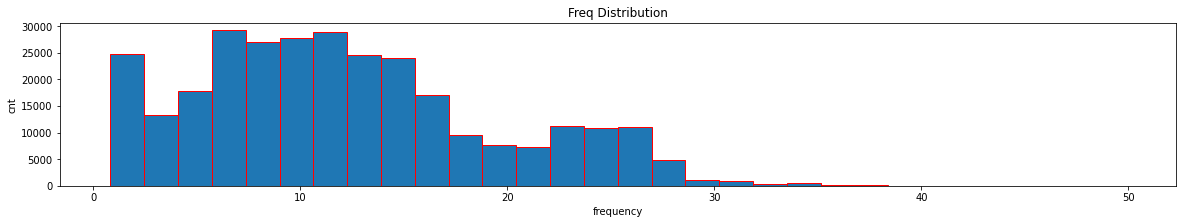

In [ ]:
# duration is skewed to the right
plt.hist(Xy['duration'], edgecolor="red", bins=30)
plt.title('Freq Distribution')
plt.xlabel('frequency')
plt.ylabel('cnt')
plt.show()

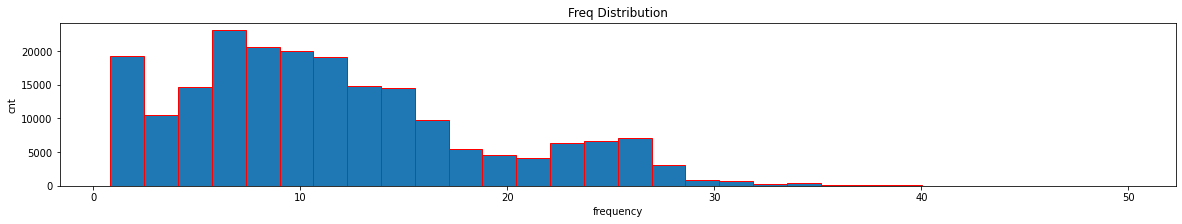

In [ ]:
# duration is skewed to the right for Economy
plt.hist(Xy_e['duration'], edgecolor="red", bins=30)
plt.title('Freq Distribution')
plt.xlabel('frequency')
plt.ylabel('cnt')
plt.show()

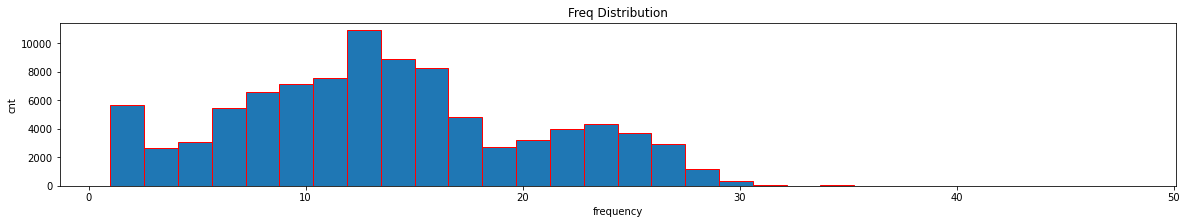

In [ ]:
#duration is skewed to the right for Business
plt.hist(Xy_b['duration'], edgecolor="red", bins=30)
plt.title('Freq Distribution')
plt.xlabel('frequency')
plt.ylabel('cnt')
plt.show()

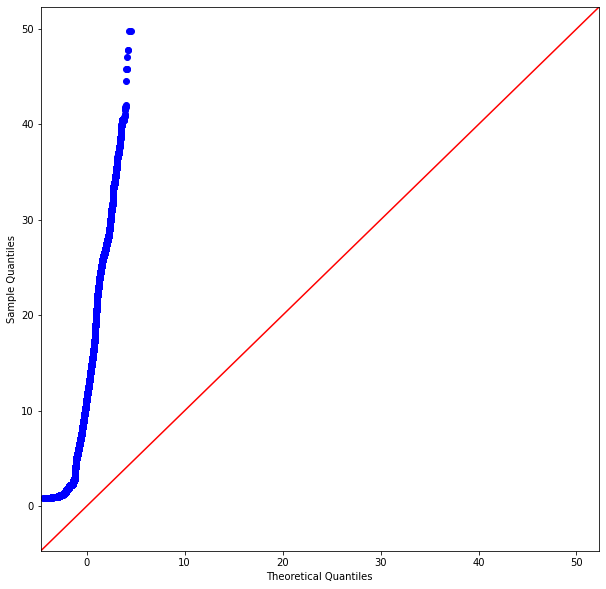

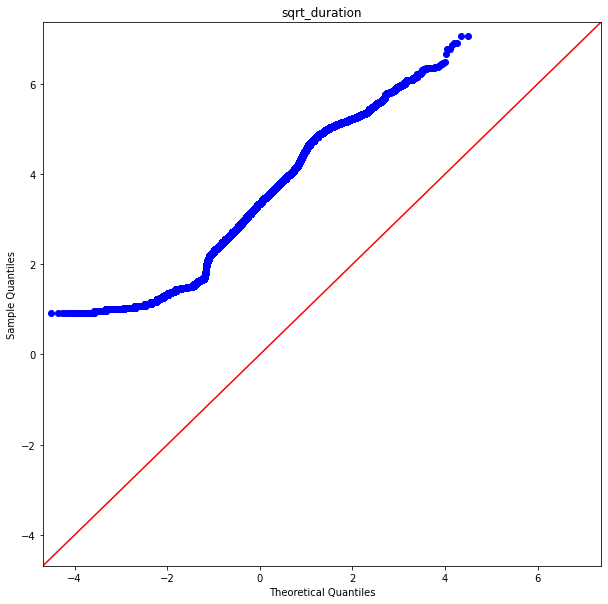

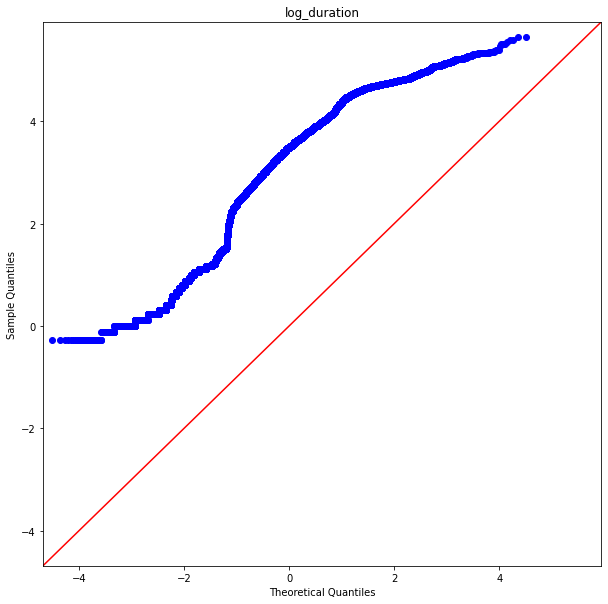

In [ ]:
#  qq plot for normal, sqrt and log transform of duration
plt.rcParams["figure.figsize"] = (10,10)
sm.qqplot(Xy['duration'],  line='45')
plt.show()

plt.rcParams["figure.figsize"] = (10,10)
sm.qqplot(np.sqrt(Xy['duration']), line='45')
plt.title('sqrt_duration')
plt.show()

plt.rcParams["figure.figsize"] = (10,10)
sm.qqplot(np.log2(Xy['duration']), line='45')
plt.title('log_duration')
plt.show()

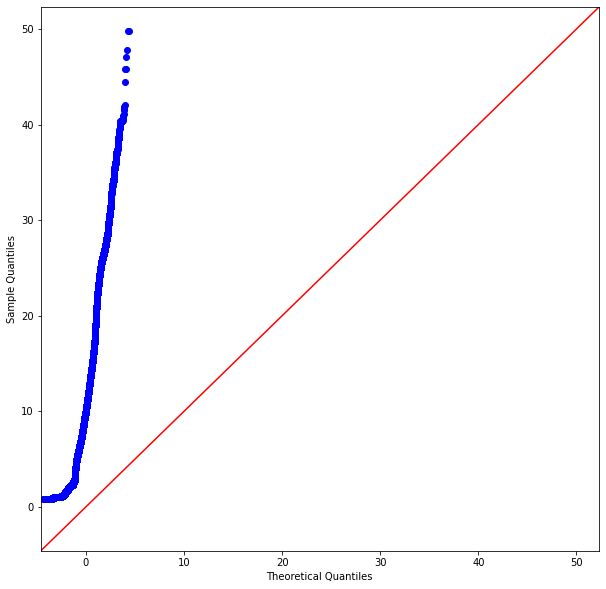

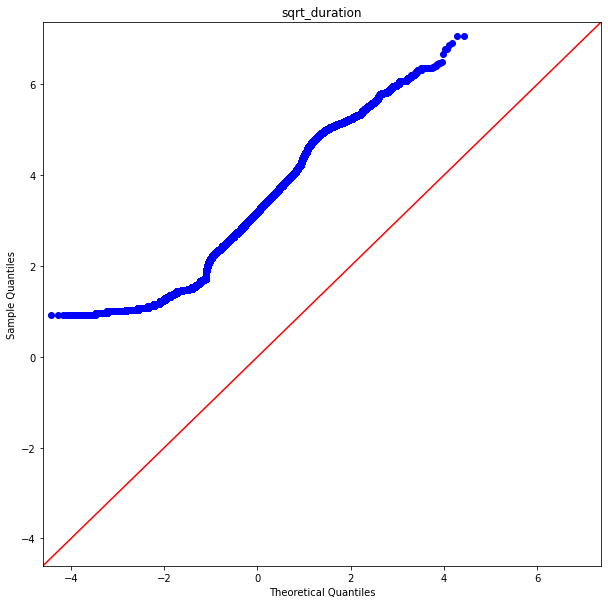

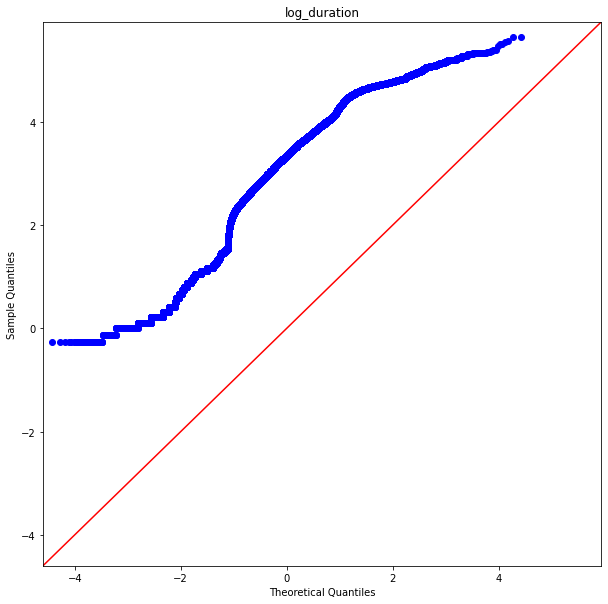

In [ ]:
#  qq plot for normal, sqrt and log transform of duration for Economy
plt.rcParams["figure.figsize"] = (10,10)
sm.qqplot(Xy_e['duration'],  line='45')
plt.show()

plt.rcParams["figure.figsize"] = (10,10)
sm.qqplot(np.sqrt(Xy_e['duration']), line='45')
plt.title('sqrt_duration')
plt.show()

plt.rcParams["figure.figsize"] = (10,10)
sm.qqplot(np.log2(Xy_e['duration']), line='45')
plt.title('log_duration')
plt.show()

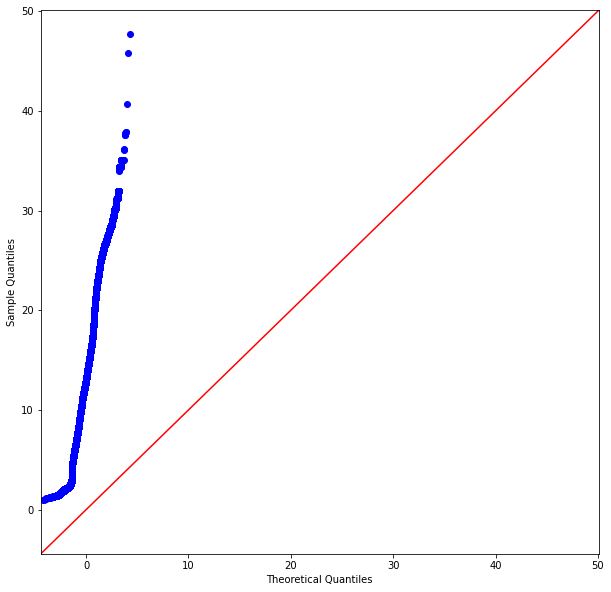

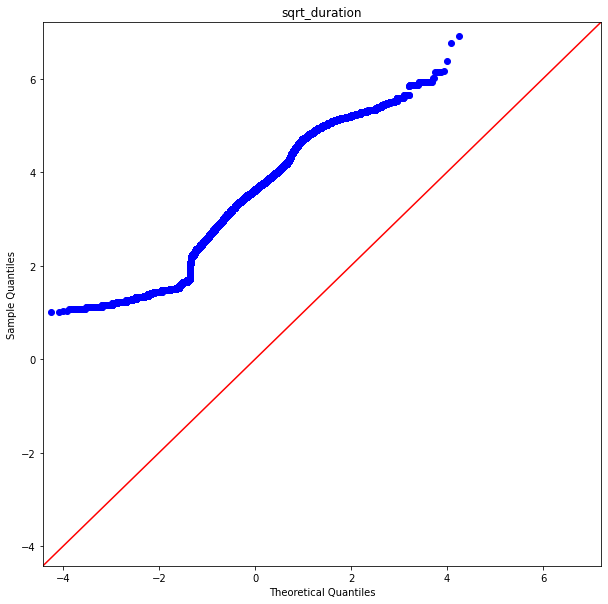

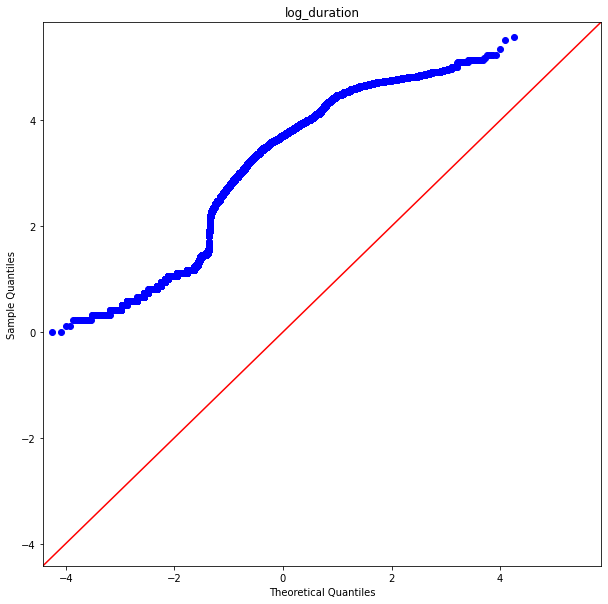

In [ ]:
#  qq plot for normal, sqrt and log transform of duration for Business
plt.rcParams["figure.figsize"] = (10,10)
sm.qqplot(Xy_b['duration'],  line='45')
plt.show()

plt.rcParams["figure.figsize"] = (10,10)
sm.qqplot(np.sqrt(Xy_b['duration']), line='45')
plt.title('sqrt_duration')
plt.show()

plt.rcParams["figure.figsize"] = (10,10)
sm.qqplot(np.log2(Xy_b['duration']), line='45')
plt.title('log_duration')
plt.show()

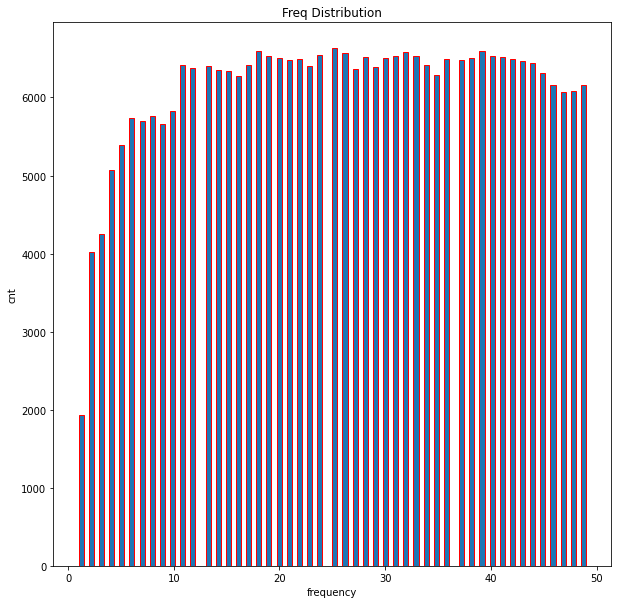

In [ ]:
# days_left is uniformly distributed
plt.hist(Xy['days_left'], edgecolor="red", bins=100)
plt.title('Freq Distribution')
plt.xlabel('frequency')
plt.ylabel('cnt')
plt.show()

In [ ]:
def add_features(data):
  df = data.copy()

  df['sqrt_duration'] = np.sqrt(df['duration'])

  # hubs
  hubs_list = ['Mumbia', 'Delhi']

  df['source_hub'] = df['source_city'].isin(hubs_list).astype(int)
  df['destination_hub'] = df['destination_city'].isin(hubs_list).astype(int)

  df['hub_to_hub'] = df['source_hub'] * df['destination_hub']

  # peak demand flight
  # https://www.thehindu.com/news/national/peak-hour-flights-may-get-costlier/article24428066.ece
  peak_list = ['Early_morning', 'Morning', 'Evening', 'Night']

  df['departure_peak'] = df['departure_time'].isin(peak_list).astype(int)
  df['arrival_peak'] = df['arrival_time'].isin(peak_list).astype(int)

  df['peak_to_peak'] = df['departure_peak'] * df['arrival_peak']

  quant_cols=['duration','days_left']
  for col in quant_cols:
    col2 = col + '^2'
    col3 = col + '^3'

    df[col2] = df[col]**2
    df[col3] = df[col]**3

  return df

In [ ]:
Xy = add_features(data=Xy)
Xy_b = add_features(data=Xy_b)
Xy_e = add_features(data=Xy_e)

Xy_ohe = add_features(data=Xy_ohe)
Xy_b_ohe = add_features(data=Xy_b_ohe)
Xy_e_ohe = add_features(data=Xy_e_ohe)

In [ ]:
le_drop_list = ohe_list + [target]

X = Xy.drop(le_drop_list, axis=1).copy()
y = Xy[[target]].copy()

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, 
                                                                    y, 
                                                                    test_size=0.20, 
                                                                    random_state=random_state) 

X.columns

Index(['duration', 'days_left', 'class_e', 'airline_e', 'source_city_e',
       'destination_city_e', 'departure_time_e', 'arrival_time_e', 'stops_e',
       'sqrt_duration', 'source_hub', 'destination_hub', 'hub_to_hub',
       'departure_peak', 'arrival_peak', 'peak_to_peak', 'duration^2',
       'duration^3', 'days_left^2', 'days_left^3'],
      dtype='object')

In [ ]:
# Xy_e and Xy_b
X_e = Xy_e.drop(le_drop_list, axis=1).copy()
y_e = Xy_e[[target]].copy()

X_e_train, X_e_test, y_e_train, y_e_test = model_selection.train_test_split(X_e, 
                                                                    y_e, 
                                                                    test_size=0.20, 
                                                                    random_state=random_state) 

X_e.columns

Index(['duration', 'days_left', 'class_e', 'airline_e', 'source_city_e',
       'destination_city_e', 'departure_time_e', 'arrival_time_e', 'stops_e',
       'sqrt_duration', 'source_hub', 'destination_hub', 'hub_to_hub',
       'departure_peak', 'arrival_peak', 'peak_to_peak', 'duration^2',
       'duration^3', 'days_left^2', 'days_left^3'],
      dtype='object')

In [ ]:
# Xy_e and Xy_b
X_b = Xy_b.drop(le_drop_list, axis=1).copy()
y_b = Xy_b[[target]].copy()

X_b_train, X_b_test, y_b_train, y_b_test = model_selection.train_test_split(X_b, 
                                                                    y_b, 
                                                                    test_size=0.20, 
                                                                    random_state=random_state) 

X_b.columns

Index(['duration', 'days_left', 'class_e', 'airline_e', 'source_city_e',
       'destination_city_e', 'departure_time_e', 'arrival_time_e', 'stops_e',
       'sqrt_duration', 'source_hub', 'destination_hub', 'hub_to_hub',
       'departure_peak', 'arrival_peak', 'peak_to_peak', 'duration^2',
       'duration^3', 'days_left^2', 'days_left^3'],
      dtype='object')

In [ ]:
# list for dropping one_hot_encode
ohe_drop_list = ohe_list + ['class_Business',
                 'airline_Air_India',
                 'source_city_Chennai',
                 'destination_city_Chennai',
                 'departure_time_Early_Morning',
                 'arrival_time_Early_Morning',
                 'stops_zero'
                 ] + [target]


X_ohe = Xy_ohe.drop(ohe_drop_list, axis=1).copy()
y_ohe = Xy_ohe[[target]].copy()

X_ohe_train, X_ohe_test, y_ohe_train, y_ohe_test = model_selection.train_test_split(X_ohe, 
                                                                    y_ohe, 
                                                                    test_size=0.20, 
                                                                    random_state=random_state) 

X_ohe.columns

Index(['duration', 'days_left', 'class_Economy', 'airline_AirAsia',
       'airline_GO_FIRST', 'airline_Indigo', 'airline_SpiceJet',
       'airline_Vistara', 'source_city_Bangalore', 'source_city_Delhi',
       'source_city_Hyderabad', 'source_city_Kolkata', 'source_city_Mumbai',
       'destination_city_Bangalore', 'destination_city_Delhi',
       'destination_city_Hyderabad', 'destination_city_Kolkata',
       'destination_city_Mumbai', 'departure_time_Afternoon',
       'departure_time_Evening', 'departure_time_Late_Night',
       'departure_time_Morning', 'departure_time_Night',
       'arrival_time_Afternoon', 'arrival_time_Evening',
       'arrival_time_Late_Night', 'arrival_time_Morning', 'arrival_time_Night',
       'stops_one', 'stops_two_or_more', 'sqrt_duration', 'source_hub',
       'destination_hub', 'hub_to_hub', 'departure_peak', 'arrival_peak',
       'peak_to_peak', 'duration^2', 'duration^3', 'days_left^2',
       'days_left^3'],
      dtype='object')

In [ ]:
ohe_drop_list = ohe_list + ['class_Business',
                 'airline_Air_India',
                 'source_city_Chennai',
                 'destination_city_Chennai',
                 'departure_time_Early_Morning',
                 'arrival_time_Early_Morning',
                 'stops_zero'
                 ] + [target, 'class_Economy']

# Xy_e and Xy_b
X_e_ohe = Xy_e_ohe.drop(ohe_drop_list, axis=1).copy()
y_e_ohe = Xy_e_ohe[[target]].copy()

X_e_ohe_train, X_e_ohe_test, y_e_ohe_train, y_e_ohe_test = model_selection.train_test_split(X_e_ohe, 
                                                                    y_e_ohe, 
                                                                    test_size=0.20, 
                                                                    random_state=random_state) 

X_e_ohe.columns

Index(['duration', 'days_left', 'airline_AirAsia', 'airline_GO_FIRST',
       'airline_Indigo', 'airline_SpiceJet', 'airline_Vistara',
       'source_city_Bangalore', 'source_city_Delhi', 'source_city_Hyderabad',
       'source_city_Kolkata', 'source_city_Mumbai',
       'destination_city_Bangalore', 'destination_city_Delhi',
       'destination_city_Hyderabad', 'destination_city_Kolkata',
       'destination_city_Mumbai', 'departure_time_Afternoon',
       'departure_time_Evening', 'departure_time_Late_Night',
       'departure_time_Morning', 'departure_time_Night',
       'arrival_time_Afternoon', 'arrival_time_Evening',
       'arrival_time_Late_Night', 'arrival_time_Morning', 'arrival_time_Night',
       'stops_one', 'stops_two_or_more', 'sqrt_duration', 'source_hub',
       'destination_hub', 'hub_to_hub', 'departure_peak', 'arrival_peak',
       'peak_to_peak', 'duration^2', 'duration^3', 'days_left^2',
       'days_left^3'],
      dtype='object')

In [ ]:
X_b_ohe = Xy_b_ohe.drop(ohe_drop_list, axis=1).copy()
y_b_ohe = Xy_b_ohe[[target]].copy()

X_b_ohe_train, X_b_ohe_test, y_b_ohe_train, y_b_ohe_test = model_selection.train_test_split(X_b_ohe, 
                                                                    y_b_ohe, 
                                                                    test_size=0.20, 
                                                                    random_state=random_state) 

X_b_ohe.columns

Index(['duration', 'days_left', 'airline_AirAsia', 'airline_GO_FIRST',
       'airline_Indigo', 'airline_SpiceJet', 'airline_Vistara',
       'source_city_Bangalore', 'source_city_Delhi', 'source_city_Hyderabad',
       'source_city_Kolkata', 'source_city_Mumbai',
       'destination_city_Bangalore', 'destination_city_Delhi',
       'destination_city_Hyderabad', 'destination_city_Kolkata',
       'destination_city_Mumbai', 'departure_time_Afternoon',
       'departure_time_Evening', 'departure_time_Late_Night',
       'departure_time_Morning', 'departure_time_Night',
       'arrival_time_Afternoon', 'arrival_time_Evening',
       'arrival_time_Late_Night', 'arrival_time_Morning', 'arrival_time_Night',
       'stops_one', 'stops_two_or_more', 'sqrt_duration', 'source_hub',
       'destination_hub', 'hub_to_hub', 'departure_peak', 'arrival_peak',
       'peak_to_peak', 'duration^2', 'duration^3', 'days_left^2',
       'days_left^3'],
      dtype='object')

### Linear Regression

In [ ]:
clf_lr = linear_model.LinearRegression(n_jobs=-1)

# two parameters to optimize
fit_intercept_list = [True, False]
positive_list = [True, False]

# select the optimal parameters
gs_lr = model_selection.GridSearchCV(
    estimator=clf_lr,
    param_grid=[{
        'fit_intercept': fit_intercept_list,
        'positive': positive_list}],
    scoring=scoring,                                      
    cv=inner_cv) 

gs_lr_fit = gs_lr.fit(X_ohe_train,y_ohe_train)

print('General')
print("Non-nested Tuning:")
print("  Model: ", gs_lr_fit.best_estimator_)
print("  Parameterization: ", gs_lr_fit.best_params_)
print("  Non-nested CV {} score: ".format(scoring), round(-1 * gs_lr_fit.best_score_, 2))


# generalization performance
nested_gs_lr_fit= model_selection.cross_val_score(
    gs_lr_fit, 
    X=X_ohe_train, 
    y=y_ohe_train, 
    scoring=scoring,
    cv=outer_cv)

print("\nNested Tuning:")
print("  Nested CV {} mean: ".format(scoring), round(-1 * nested_gs_lr_fit.mean(), 2), " with st.dev (+/-): ", round(nested_gs_lr_fit.std(),2))

General
Non-nested Tuning:
  Model:  LinearRegression(n_jobs=-1)
  Parameterization:  {'fit_intercept': True, 'positive': False}
  Non-nested CV neg_root_mean_squared_error score:  6603.29

Nested Tuning:
  Nested CV neg_root_mean_squared_error mean:  6603.29  with st.dev (+/-):  20.53


In [ ]:
clf_lr = linear_model.LinearRegression(n_jobs=-1)

# two parameters to optimize
fit_intercept_list = [True, False]
positive_list = [True, False]

# select the optimal parameters
gs_lr = model_selection.GridSearchCV(
    estimator=clf_lr,
    param_grid=[{
        'fit_intercept': fit_intercept_list,
        'positive': positive_list}],
    scoring=scoring,                                      
    cv=inner_cv) 

gs_lr_fit = gs_lr.fit(X_e_ohe_train,y_e_ohe_train)

print('Economy')
print("Non-nested Tuning:")
print("  Model: ", gs_lr_fit.best_estimator_)
print("  Parameterization: ", gs_lr_fit.best_params_)
print("  Non-nested CV {} score: ".format(scoring), round(-1 * gs_lr_fit.best_score_, 2))


# generalization performance
nested_gs_lr_fit= model_selection.cross_val_score(
    gs_lr_fit, 
    X=X_e_ohe_train, 
    y=y_e_ohe_train, 
    scoring=scoring,
    cv=outer_cv)

print("\nNested Tuning:")
print("  Nested CV {} mean: ".format(scoring), round(-1 * nested_gs_lr_fit.mean(), 2), " with st.dev (+/-): ", round(nested_gs_lr_fit.std(),2))

e_rmse = -1 * nested_gs_tree_fit.mean()

Economy
Non-nested Tuning:
  Model:  LinearRegression(n_jobs=-1)
  Parameterization:  {'fit_intercept': True, 'positive': False}
  Non-nested CV neg_root_mean_squared_error score:  2345.68

Nested Tuning:
  Nested CV neg_root_mean_squared_error mean:  2345.68  with st.dev (+/-):  9.13


In [ ]:
clf_lr = linear_model.LinearRegression(n_jobs=-1)

# two parameters to optimize
fit_intercept_list = [True, False]
positive_list = [True, False]

# select the optimal parameters
gs_lr = model_selection.GridSearchCV(
    estimator=clf_lr,
    param_grid=[{
        'fit_intercept': fit_intercept_list,
        'positive': positive_list}],
    scoring=scoring,                                      
    cv=inner_cv) 

gs_lr_fit = gs_lr.fit(X_b_ohe_train,y_b_ohe_train)

print('Business')
print("Non-nested Tuning:")
print("  Model: ", gs_lr_fit.best_estimator_)
print("  Parameterization: ", gs_lr_fit.best_params_)
print("  Non-nested CV {} score: ".format(scoring), round(-1 * gs_lr_fit.best_score_, 2))


# generalization performance
nested_gs_lr_fit= model_selection.cross_val_score(
    gs_lr_fit, 
    X=X_b_ohe_train, 
    y=y_b_ohe_train, 
    scoring=scoring,
    cv=outer_cv)

print("\nNested Tuning:")
print("  Nested CV {} mean: ".format(scoring), round(-1 * nested_gs_lr_fit.mean(), 2), " with st.dev (+/-): ", round(nested_gs_lr_fit.std(),2))

b_rmse = -1 * nested_gs_tree_fit.mean()

Business
Non-nested Tuning:
  Model:  LinearRegression(n_jobs=-1)
  Parameterization:  {'fit_intercept': True, 'positive': False}
  Non-nested CV neg_root_mean_squared_error score:  8544.08

Nested Tuning:
  Nested CV neg_root_mean_squared_error mean:  8544.08  with st.dev (+/-):  50.31


In [ ]:
avg_rmse = calculate_avg_score(e_rmse, b_rmse)
print(round(avg_rmse, 2))

4742.49


### Decision Tree

In [ ]:
# create a model
clf_tree = tree.DecisionTreeRegressor(criterion='squared_error',
                                      random_state=random_state)

# two parameters to optimize
min_samples_split_list = [10, 20, 30, 40, 50]
max_depth_list = [10, 20, 30, 40, 50]

# select the optimal parameters 
gs_tree = model_selection.GridSearchCV(estimator=clf_tree,
                                       param_grid=[{
                                           'min_samples_split': min_samples_split_list,
                                           'max_depth': max_depth_list}],
                                       scoring=scoring,                                      
                                       cv=inner_cv) 

gs_tree_fit = gs_tree.fit(X_train,y_train)

print('General')
print("Non-nested Tuning:")
print("  Model: ", gs_tree_fit.best_estimator_)
print("  Parameterization: ", gs_tree_fit.best_params_)
print("  Non-nested CV {} score: ".format(scoring), round(-1 * gs_tree_fit.best_score_, 2))

# generalization performance
nested_gs_tree_fit = model_selection.cross_val_score(gs_tree_fit, 
                                                     X=X_train, 
                                                     y=y_train, 
                                                     scoring=scoring,
                                                     cv=outer_cv)

print("nested Tuning:")
print("  Nested CV {} mean: ".format(scoring), round(-1 * nested_gs_tree_fit.mean(),2), " with st.dev (+/-): ", round(nested_gs_tree_fit.std(),2))

General
Non-nested Tuning:
  Model:  DecisionTreeRegressor(max_depth=30, min_samples_split=30, random_state=42)
  Parameterization:  {'max_depth': 30, 'min_samples_split': 30}
  Non-nested CV neg_root_mean_squared_error score:  2944.26
nested Tuning:
  Nested CV neg_root_mean_squared_error mean:  2944.1  with st.dev (+/-):  17.59


In [ ]:
# create a model
clf_tree = tree.DecisionTreeRegressor(criterion='squared_error',
                                      random_state=random_state)

# two parameters to optimize
min_samples_split_list = [10, 20, 30, 40, 50]
max_depth_list = [10, 20, 30, 40, 50]

# select the optimal parameters 
gs_tree = model_selection.GridSearchCV(estimator=clf_tree,
                                       param_grid=[{
                                           'min_samples_split': min_samples_split_list,
                                           'max_depth': max_depth_list}],
                                       scoring=scoring,                                      
                                       cv=inner_cv) 

gs_tree_fit = gs_tree.fit(X_e_train,y_e_train)

print('Economy')
print("Non-nested Tuning:")
print("  Model: ", gs_tree_fit.best_estimator_)
print("  Parameterization: ", gs_tree_fit.best_params_)
print("  Non-nested CV {} score: ".format(scoring), round(-1 * gs_tree_fit.best_score_, 2))

# generalization performance
nested_gs_tree_fit = model_selection.cross_val_score(gs_tree_fit, 
                                                     X=X_e_train, 
                                                     y=y_e_train, 
                                                     scoring=scoring,
                                                     cv=outer_cv)

print("nested Tuning:")
print("  Nested CV {} mean: ".format(scoring), round(-1 * nested_gs_tree_fit.mean(),2), " with st.dev (+/-): ", round(nested_gs_tree_fit.std(),2))

e_rmse = -1 * nested_gs_tree_fit.mean()

Economy
Non-nested Tuning:
  Model:  DecisionTreeRegressor(max_depth=40, min_samples_split=20, random_state=42)
  Parameterization:  {'max_depth': 40, 'min_samples_split': 20}
  Non-nested CV neg_root_mean_squared_error score:  1690.15
nested Tuning:
  Nested CV neg_root_mean_squared_error mean:  1690.33  with st.dev (+/-):  14.73


In [ ]:
# create a model
clf_tree = tree.DecisionTreeRegressor(criterion='squared_error',
                                      random_state=random_state)

# two parameters to optimize
min_samples_split_list = [10, 20, 30, 40, 50]
max_depth_list = [10, 20, 30, 40, 50]

# select the optimal parameters 
gs_tree = model_selection.GridSearchCV(estimator=clf_tree,
                                       param_grid=[{
                                           'min_samples_split': min_samples_split_list,
                                           'max_depth': max_depth_list}],
                                       scoring=scoring,                                      
                                       cv=inner_cv) 

gs_tree_fit = gs_tree.fit(X_b_train,y_b_train)

print('Business')
print("Non-nested Tuning:")
print("  Model: ", gs_tree_fit.best_estimator_)
print("  Parameterization: ", gs_tree_fit.best_params_)
print("  Non-nested CV {} score: ".format(scoring), round(-1 * gs_tree_fit.best_score_, 2))

# generalization performance
nested_gs_tree_fit = model_selection.cross_val_score(gs_tree_fit, 
                                                     X=X_b_train, 
                                                     y=y_b_train, 
                                                     scoring=scoring,
                                                     cv=outer_cv)

print("nested Tuning:")
print("  Nested CV {} mean: ".format(scoring), round(-1 * nested_gs_tree_fit.mean(),2), " with st.dev (+/-): ", round(nested_gs_tree_fit.std(),2))

b_rmse = -1 * nested_gs_tree_fit.mean()

Business
Non-nested Tuning:
  Model:  DecisionTreeRegressor(max_depth=40, min_samples_split=30, random_state=42)
  Parameterization:  {'max_depth': 40, 'min_samples_split': 30}
  Non-nested CV neg_root_mean_squared_error score:  4711.02
nested Tuning:
  Nested CV neg_root_mean_squared_error mean:  4711.14  with st.dev (+/-):  65.6


In [ ]:
avg_rmse = calculate_avg_score(e_rmse, b_rmse)
print(round(avg_rmse, 2))

2631.2


## Best Model
Perform grid-search one more time with a more specific set of hyperparameters.

### Economy

In [ ]:
# create a model
clf_tree = tree.DecisionTreeRegressor(criterion='squared_error',
                                      random_state=random_state)

# two parameters to optimize
# pick the optimal number
min_samples_split_list = [14, 15, 16, 18, 20, 22, 24, 25, 26]
max_depth_list = [34, 35, 36, 38, 40, 42, 44, 45, 46]

# select the optimal parameters 
gs_tree = model_selection.GridSearchCV(estimator=clf_tree,
                                       param_grid=[{
                                           'min_samples_split': min_samples_split_list,
                                           'max_depth': max_depth_list}],
                                       scoring=scoring,                                      
                                       cv=inner_cv) 

gs_tree_fit = gs_tree.fit(X_e_train,y_e_train)

print('Economy')
print("Non-nested Tuning:")
print("  Model: ", gs_tree_fit.best_estimator_)
print("  Parameterization: ", gs_tree_fit.best_params_)
print("  Non-nested CV {} score: ".format(scoring), round(-1 * gs_tree_fit.best_score_, 2))

Economy
Non-nested Tuning:
  Model:  DecisionTreeRegressor(max_depth=35, min_samples_split=16, random_state=42)
  Parameterization:  {'max_depth': 35, 'min_samples_split': 16}
  Non-nested CV neg_root_mean_squared_error score:  1688.18


In [ ]:
clf_tree = tree.DecisionTreeRegressor(criterion='squared_error',
                                      min_samples_split=16,
                                      max_depth=35,
                                      random_state=random_state)

clf_tree_fit = clf_tree.fit(X_e_train, y_e_train)

y_pred = clf_tree_fit.predict(X_e_test)

e_rmse = metrics.mean_squared_error(y_pred, y_e_test, squared=False)

### Business

In [ ]:
# create a model
clf_tree = tree.DecisionTreeRegressor(criterion='squared_error',
                                      random_state=random_state)

# two parameters to optimize
min_samples_split_list = [24, 25, 26, 28, 30, 32, 34, 35, 36]
max_depth_list = [34, 35, 36, 38, 40, 42, 44, 45, 46]

# select the optimal parameters
# pick the optimal number
gs_tree = model_selection.GridSearchCV(estimator=clf_tree,
                                       param_grid=[{
                                           'min_samples_split': min_samples_split_list,
                                           'max_depth': max_depth_list}],
                                       scoring=scoring,                                      
                                       cv=inner_cv) 

gs_tree_fit = gs_tree.fit(X_b_train,y_b_train)

print('Business')
print("Non-nested Tuning:")
print("  Model: ", gs_tree_fit.best_estimator_)
print("  Parameterization: ", gs_tree_fit.best_params_)
print("  Non-nested CV {} score: ".format(scoring), round(-1 * gs_tree_fit.best_score_, 2))

Business
Non-nested Tuning:
  Model:  DecisionTreeRegressor(max_depth=34, min_samples_split=32, random_state=42)
  Parameterization:  {'max_depth': 34, 'min_samples_split': 32}
  Non-nested CV neg_root_mean_squared_error score:  4707.1


In [ ]:
clf_tree = tree.DecisionTreeRegressor(criterion='squared_error',
                                      min_samples_split=32,
                                      max_depth=34,
                                      random_state=random_state)

clf_tree_fit = clf_tree.fit(X_b_train, y_b_train)

y_pred = clf_tree_fit.predict(X_b_test)

b_rmse = metrics.mean_squared_error(y_pred, y_b_test, squared=False)

In [ ]:
avg_rmse = calculate_avg_score(e_rmse, b_rmse)
print(round(avg_rmse, 2))

2499.51
